In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append("plotting")
import plotting_feature_extraction
import importlib
importlib.reload(plotting_feature_extraction)

<module 'plotting_feature_extraction' from '/home/frankwoods/Desktop/lassie/plotting/plotting_feature_extraction.py'>

In [2]:
curves_data = []
filename_list = []
for filename in os.listdir("data/cleaned_data"):
    df = pd.read_csv(f"data/cleaned_data/{filename}").drop(columns=["Unnamed: 0"])
    filename_list.append(filename)
    curves_data.append(df)
print(filename_list)
print(curves_data[0])

['WS25_Aug5_Loc1A_T1_F10_0958.csv', 'WS23_L3_T1_P_16.csv', 'WS25_Aug5_Loc1A_T1_F15_1026.csv', 'WS25_Aug5_Loc1A_T1_F6_0930.csv', 'WS23_L2_T2_P_3.csv', 'WS23_L2_T1_P_4.csv', 'WS23_L1_T1_P_17.csv', 'WS23_L2_T2_P_2.csv', 'WS23_L1_T1_P_8.csv', 'WS23_L1_T1_P_21.csv', 'WS23_L1_T1_P_16.csv', 'WS23_L3_T1_P_11.csv', 'WS25_Aug6_Loc1A_T1_F22_0653.csv', 'WS23_L3_T1_P_25.csv', 'WS23_L1_T1_P_5.csv', 'WS23_L3_T1_P_9.csv', 'WS23_L2_T1_P_14.csv', 'WS23_L2_T1_P_12.csv', 'WS23_L2_T2_P_4.csv', 'WS23_L2_T1_P_9.csv', 'WS25_Aug5_Loc1A_T1_F8_0955.csv', 'WS23_L2_T1_P_13.csv', 'WS23_L1_T1_P_23.csv', 'WS23_L1_T1_P_14.csv', 'WS23_L2_T1_P_6.csv', 'WS23_L2_T1_P_16.csv', 'WS23_L2_T2_P_0.csv', 'WS23_L2_T1_P_2.csv', 'WS23_L1_T1_P_7.csv', 'WS25_Aug6_Loc1A_T1_F27_0702.csv', 'WS25_Aug6_Loc1A_T1_F21_0648_attempt2.csv', 'WS23_L1_T1_P_11.csv', 'WS25_Aug5_Loc1A_T1_F2_0919.csv', 'WS25_Aug6_Loc1A_T1_F30_0709.csv', 'WS23_L3_T1_P_17.csv', 'WS23_L3_T1_P_4.csv', 'WS23_L2_T1_P_5.csv', 'WS23_L1_T1_P_12.csv', 'WS23_L3_T1_P_29.csv', 'W

# Find Curve Shape

In [3]:
def find_curve_shape(df):
    x = df['depth'].to_numpy()
    y = df['resistance'].to_numpy()
    # create evenly spaces points
    chord = np.linspace(df['resistance'].iloc[0], df['resistance'].iloc[-1], num=len(df['depth']))
    y_diff = y - chord # makes chord the x-axis, any y_points above chord are pos, below are neg
    return np.trapezoid(y=y_diff, x=x)

# Find Force-Drop

In [4]:
def find_force_drop_subranges(df: pd.DataFrame, percent_of_max_resistance: float):
    down_moves_subrange_list = []
    resistance_max = df['resistance'].max()
    min_drop_size = resistance_max * percent_of_max_resistance
    curr_peak_idx = 0
    curr_trough_idx = 0
    in_drop_subrange = 0 # bool

    for idx in range(1, len(df['resistance'])):
        curr_peak = df['resistance'].iloc[curr_peak_idx]
        curr_trough = df['resistance'].iloc[curr_trough_idx]
        curr_resistance = df['resistance'].iloc[idx]

        if curr_resistance >= curr_peak and in_drop_subrange:
            in_drop_subrange = 0
            down_moves_subrange_list.append((curr_peak_idx, curr_trough_idx))

        if curr_resistance >= curr_peak:
            curr_peak_idx = idx
            curr_trough_idx = idx
        elif curr_peak - curr_resistance >= min_drop_size and curr_resistance < curr_trough: 
            in_drop_subrange = 1
            curr_trough_idx = idx
    
    if in_drop_subrange: down_moves_subrange_list.append((curr_peak_idx, curr_trough_idx)) 
            
    return down_moves_subrange_list

def find_largest_force_drop(df: pd.DataFrame, subrange_list: List[Tuple]):
    curr_max_drop_size = 0
    curr_max_subrange_idxs = (0,0)
    for subrange_start, subrange_end in subrange_list:
        subrange_diff = df['resistance'].iloc[subrange_start] - df['resistance'].iloc[subrange_end]
        if subrange_diff > curr_max_drop_size: 
            curr_max_drop_size = subrange_diff
            curr_max_subrange_idxs = (subrange_start, subrange_end)
    return curr_max_drop_size, curr_max_subrange_idxs

def plot(curves_data: List[pd.DataFrame], plot_idx_range: List[int], title: str = 'Depth vs Resistance'):

    all_depth_resistance_data = pd.concat(curves_data, axis=0, ignore_index=True)
    gloabl_max_depth = all_depth_resistance_data['depth'].max()
    gloabl_max_resistance = all_depth_resistance_data['resistance'].max()

    for idx in plot_idx_range:

        print(f"plot idx: {idx}")

        df = curves_data[idx]
        percent = 0.1
        subranges = find_force_drop_subranges(df, percent)
        print(f"max_resistance: {df['resistance'].max()}")
        print(f"subranges: {[(float(df['resistance'].iloc[start]), float(df['resistance'].iloc[end])) for start, end in subranges]}")
   
        plt.figure(figsize=(5, 3))
        plt.xlim(0,gloabl_max_depth)
        plt.ylim(0,gloabl_max_resistance)
        plt.plot([0,df['depth'].max()], [0,df['resistance'].iloc[df['depth'].values.argmax()]], color='red')
        plt.plot([0,df['depth'].max()], [0,df['resistance'].iloc[df['depth'].values.argmax()]], color='red')
        plt.plot([0,df['depth'].max()], [0,df['resistance'].iloc[df['depth'].values.argmax()]], color='red')

        # Plot full depth vs resistance line
        plt.plot(df['depth'], df['resistance'],linestyle='-')
        plt.xlabel('Depth (m)')
        plt.ylabel('Resistance (N)')
        plt.title(f"{title} - Plot {idx}")
        # plt.grid(True)
        plt.tight_layout()
        plt.show()



# Choose Features
IMPORTANT: If you add variables here, you must add the names to the top of plotting.py file as well

In [5]:
def extract_simple_features(df):
    res = df["resistance"]
    dep = df["depth"]
    max_res_drop_val, max_res_drop_subrange_idxs = find_largest_force_drop(df, find_force_drop_subranges(df, 0.001))
    # print(max_res_drop_val, max_res_drop_subrange_idxs)
    return pd.DataFrame({
        "overall_slope": [res.max() / dep.max()],
        "max_depth": [dep.max()],
        "max_resistance": [res.max()],
        "num_peaks": len(find_force_drop_subranges(df,0.1)) / dep.max(),
        "largest_force_drop": max_res_drop_val,
        "largest_force_drop_dep": dep.loc[max_res_drop_subrange_idxs[0]],
        "largest_force_drop_res": res.loc[max_res_drop_subrange_idxs[0]],
        "curve_shape": find_curve_shape(df),

        "first_quarter_slope": (res.loc[round(0.25 * len(res))] - res.min()) / (dep.loc[round(0.25 * len(dep))] - dep.min()),
        "second_quarter_slope": (res.loc[round(0.50 * len(res))] - res.loc[round(0.25 * len(res))]) / (dep.loc[round(0.50 * len(dep))] - dep.loc[round(0.25 * len(dep))]),
        "third_quarter_slope": (res.loc[round(0.75 * len(res))] - res.loc[round(0.50 * len(res))]) / (dep.loc[round(0.75 * len(dep))] - dep.loc[round(0.50 * len(dep))]),
        "fourth_quarter_slope": (res.max() - res.loc[round(0.75 * len(res))]) / (dep.max() - dep.loc[round(0.75 * len(dep))]),

        "quartile_1": res.quantile(0.25),
        "quartile_2": res.quantile(0.50),
        "quartile_3": res.quantile(0.75),
        "skew": res.skew(), # measurs asymmetry of a distribution around it's mean
        "kurtosis": res.kurt(), # descirbes tailedness or peakedness of a distribution
    })

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for i, df in enumerate(curves_data):
    extracted_simple_features = extract_simple_features(df)
    representation_list.append(extracted_simple_features)
print(f"example: {representation_list[0]}")

example:    overall_slope  max_depth  max_resistance  num_peaks  largest_force_drop  \
0    2365.833055   0.012042       28.489152        0.0            0.551311   

   largest_force_drop_dep  largest_force_drop_res  curve_shape  \
0                0.002413                3.178361    -0.050722   

   first_quarter_slope  second_quarter_slope  third_quarter_slope  \
0            994.36638           2203.275828          1583.053217   

   fourth_quarter_slope  quartile_1  quartile_2  quartile_3      skew  \
0           4701.320694    2.690112     9.62484   14.347273  0.822771   

   kurtosis  
0 -0.529199  


In [6]:
# plot_idx = plotting_feature_extraction.find_idxs(['_Fri_Aug__8_08_36_57_2025.csv'], filename_list)[0]
plot_idx = plotting_feature_extraction.find_idxs(['WS25_Aug6_Loc1A_T1_F31_0711.csv'], filename_list)[0]

features = representation_list[0].columns.tolist()
# plotting_feature_extraction.plot_feature_selection(features, curves_data, plot_idx)
# plotting_feature_extraction.plot_feature_selection_seperately(features, curves_data, plot_idx)

# Correlation Matrix

In [7]:
representation_df = pd.concat(representation_list, axis=0, ignore_index=True)
corr_matrix = representation_df.corr()
print(corr_matrix)

                        overall_slope  max_depth  max_resistance  num_peaks  \
overall_slope                1.000000  -0.681208        0.503160  -0.322906   
max_depth                   -0.681208   1.000000       -0.706191   0.552762   
max_resistance               0.503160  -0.706191        1.000000  -0.485887   
num_peaks                   -0.322906   0.552762       -0.485887   1.000000   
largest_force_drop          -0.362542   0.417670       -0.200156   0.626876   
largest_force_drop_dep      -0.385473   0.461244       -0.334771   0.142045   
largest_force_drop_res       0.221086  -0.321074        0.376102  -0.266734   
curve_shape                  0.118847  -0.074130       -0.034539   0.018790   
first_quarter_slope          0.873549  -0.574720        0.439238  -0.242154   
second_quarter_slope         0.930125  -0.600351        0.406654  -0.349748   
third_quarter_slope          0.927907  -0.595905        0.420758  -0.295424   
fourth_quarter_slope         0.685413  -0.585079    

# Visualize Extracted Features Histograms

3 6


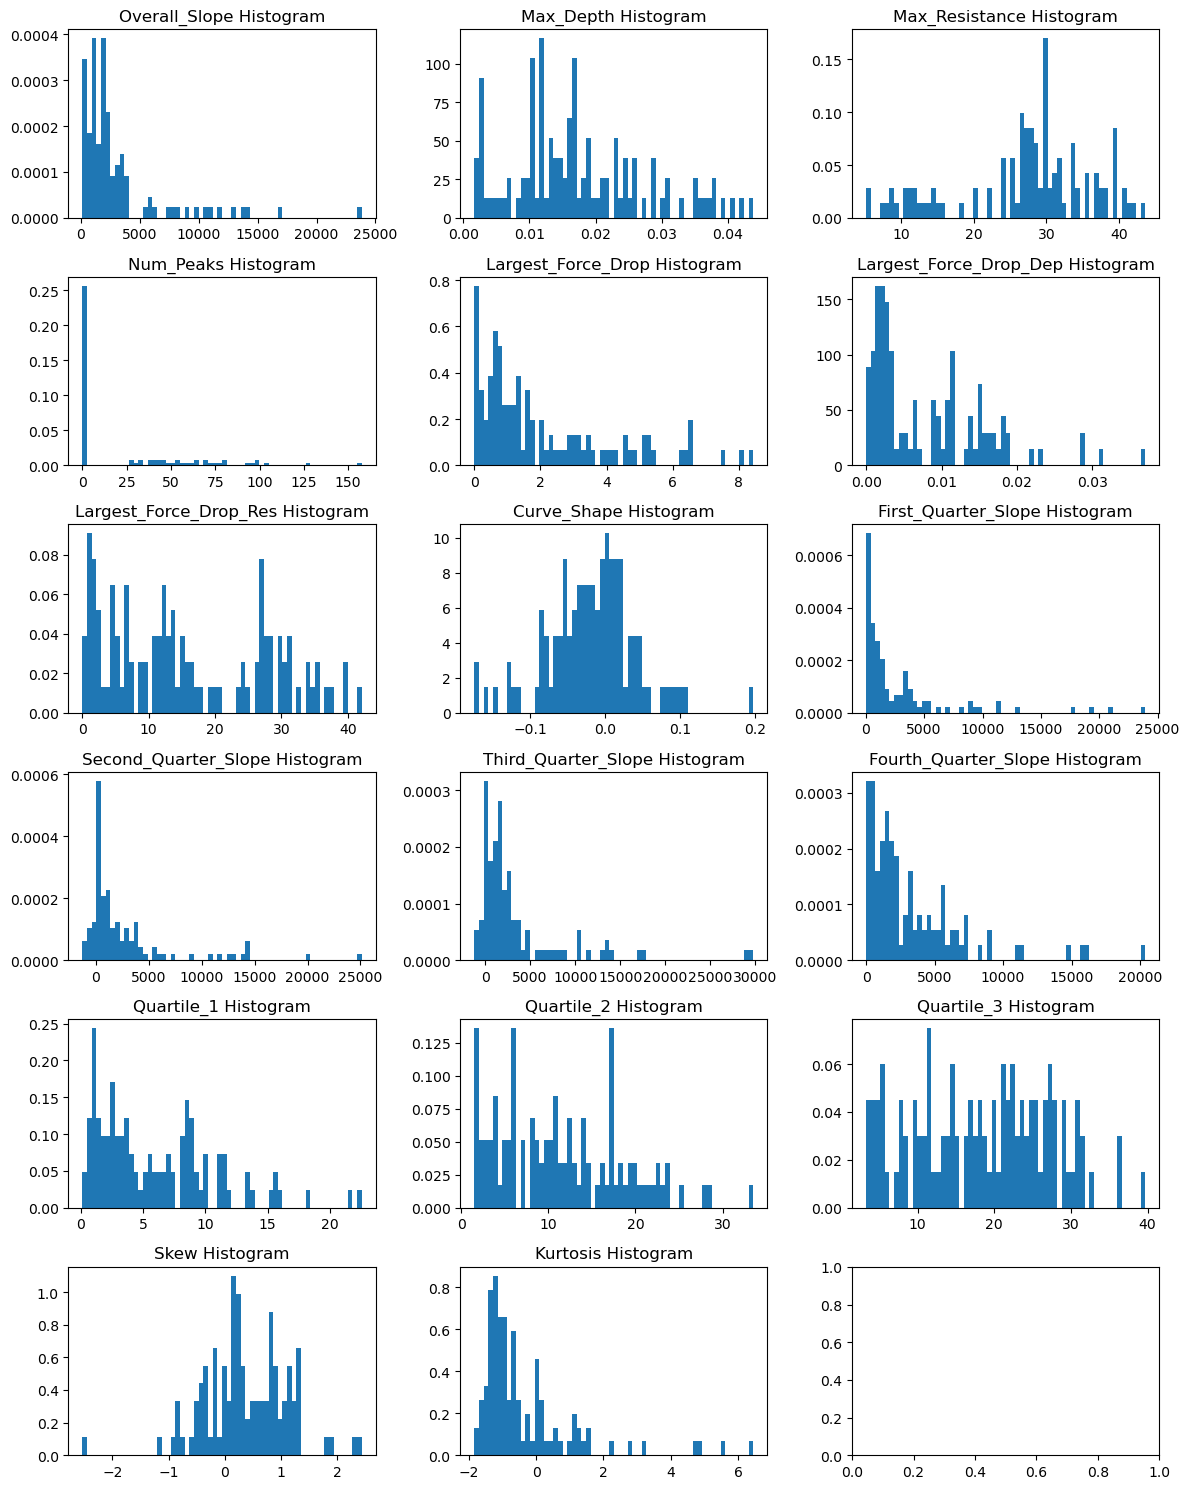

In [8]:
import math

def plot_feature_dist(representation_df):
    # for col in representation_df.columns:
    # x, y = plotting_feature_extraction.find_oriented_subplot_dims(len(representation_df.columns))
    x, y = plotting_feature_extraction.find_subplot_dims_orientation(len(representation_df.columns))
    fig, axs = plt.subplots(x,y,figsize=(round(x*2), round(y*5)))
    # fig.suptitle('Feature Histograms')
    for i, ax in enumerate(axs.flatten()):
        if i > len(representation_df.columns)-1: break
        col = representation_df.columns[i]
        ax.hist(representation_df[col], bins=60, density=True)
        ax.set_title(f"{col.title()} Histogram", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_feature_dist(representation_df)

# Scale Features

3 6


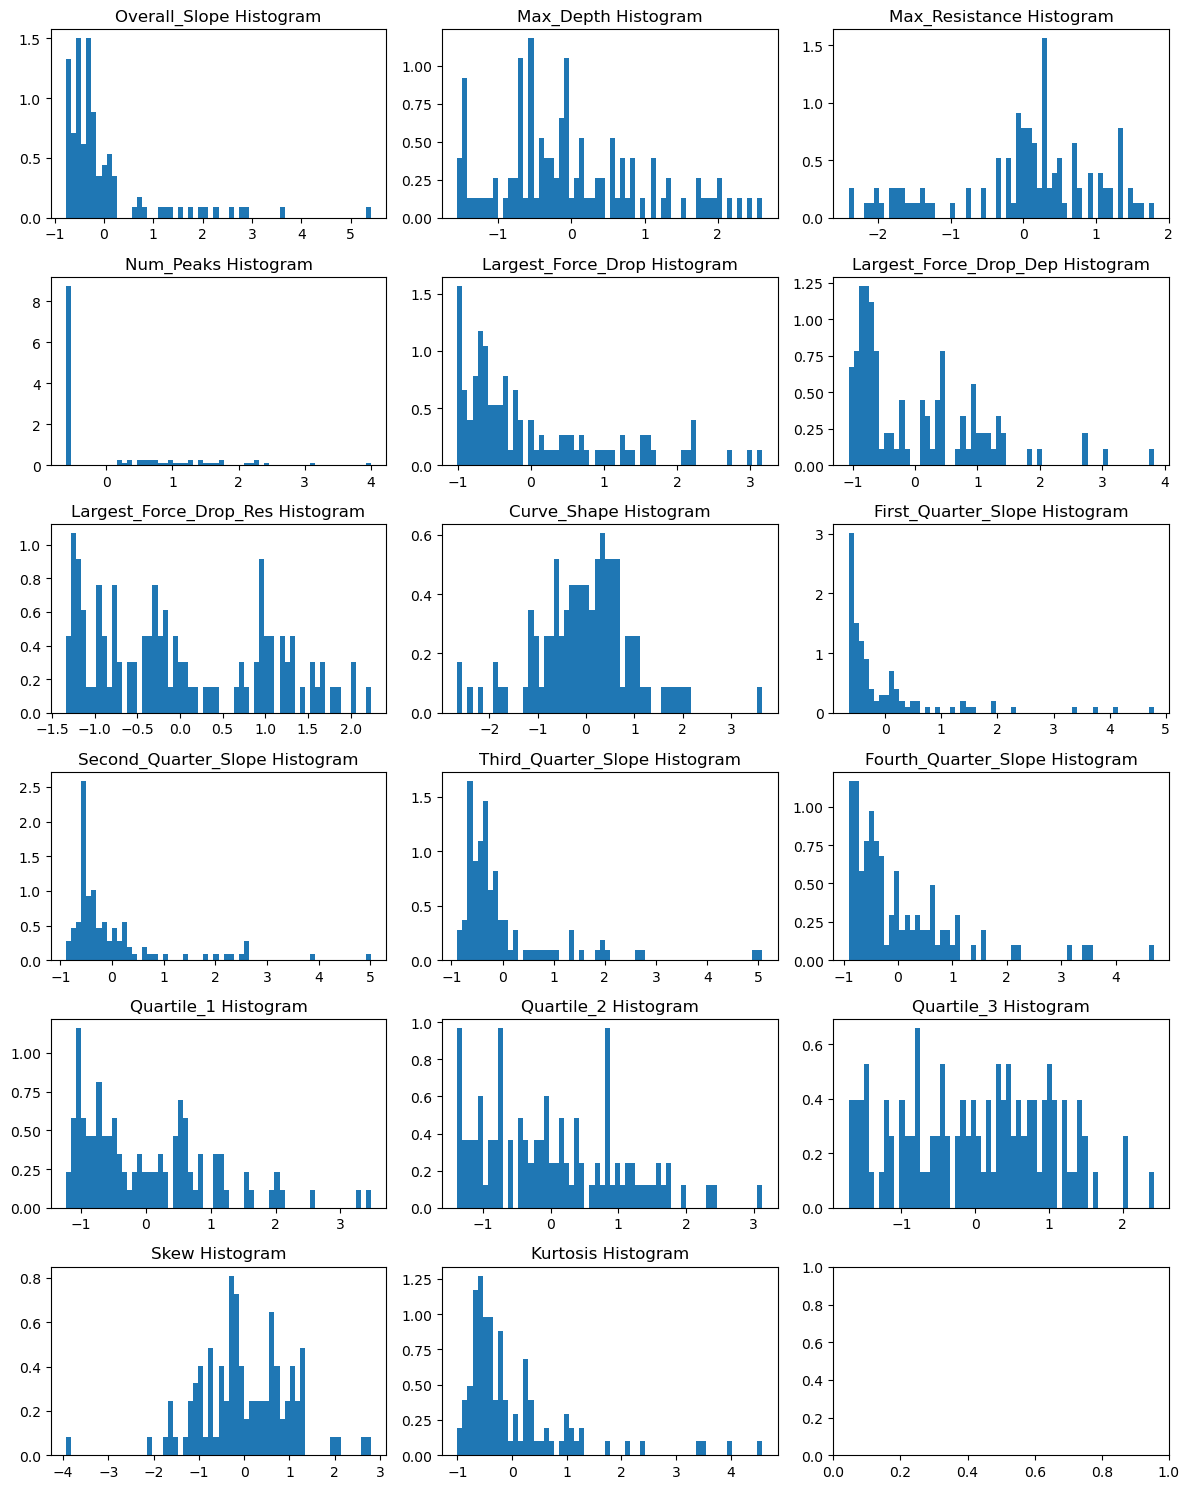

In [9]:
def transform_features(df):
    df = df.copy()  # avoid modifying original
    # Apply cube root to 'slope'
    # if "overall_slope" in df.columns: df['overall_slope'] = np.log(df['overall_slope'])
    # if "num_peaks" in df.columns: df["num_peaks"] = np.log(df['num_peaks'] + 1)
    # if 'force_drop' in df.columns: df['force_drop'] = np.log(df['force_drop'] + 1)
    # if 'largest_force_drop_res_level' in df.columns: df['largest_force_drop_res_level'] = np.log(df['largest_force_drop_res_level'] + 1)
    # Standardize
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

scaled_representations = transform_features(representation_df)
plot_feature_dist(scaled_representations)


In [10]:
corr_matrix = scaled_representations.corr()
corr_matrix.to_csv(f"data/correlation_matrix.csv", index=False)
print(corr_matrix)

                        overall_slope  max_depth  max_resistance  num_peaks  \
overall_slope                1.000000  -0.681208        0.503160  -0.322906   
max_depth                   -0.681208   1.000000       -0.706191   0.552762   
max_resistance               0.503160  -0.706191        1.000000  -0.485887   
num_peaks                   -0.322906   0.552762       -0.485887   1.000000   
largest_force_drop          -0.362542   0.417670       -0.200156   0.626876   
largest_force_drop_dep      -0.385473   0.461244       -0.334771   0.142045   
largest_force_drop_res       0.221086  -0.321074        0.376102  -0.266734   
curve_shape                  0.118847  -0.074130       -0.034539   0.018790   
first_quarter_slope          0.873549  -0.574720        0.439238  -0.242154   
second_quarter_slope         0.930125  -0.600351        0.406654  -0.349748   
third_quarter_slope          0.927907  -0.595905        0.420758  -0.295424   
fourth_quarter_slope         0.685413  -0.585079    

# Add Meta-Data

### Add FeiFei's y_labels

In [11]:
scaled_representations['filenames'] = filename_list

feifeis_filename_to_labels = {'WS23_L2_T1_P_3.csv': 'biotic crust', 'WS23_L2_T1_P_4.csv': 'biotic crust', 'WS23_L2_T1_P_6.csv': 'biotic crust', 
    'WS23_L2_T1_P_7.csv': 'biotic crust with surface nodules', 'WS23_L2_T1_P_8.csv': 'biotic crust with surface nodules', 
    'WS23_L2_T1_P_11.csv': 'strata', 'WS23_L2_T1_P_12.csv': 'strata', 'WS23_L2_T1_P_13.csv': 'crusty ripple', 
    'WS23_L2_T1_P_14.csv': 'strata', 'WS23_L2_T1_P_15.csv': 'strata', 'WS23_L2_T1_P_16.csv': 'abiotic crust on top of strata', 
    'WS23_L3_T1_P_1.csv': 'abiotic crust', 'WS23_L3_T1_P_3.csv': 'strong biotic crust', 'WS23_L3_T1_P_4.csv': 'abiotic crust', 
    'WS23_L3_T1_P_5.csv': 'abiotic crust', 'WS23_L3_T1_P_6.csv': 'abiotic crust', 'WS23_L3_T1_P_7.csv': 'abiotic crust', 
    'WS23_L3_T1_P_8.csv': 'abiotic crust', 'WS23_L3_T1_P_9.csv': 'strata', 'WS23_L3_T1_P_10.csv': 'crusty ripple', 
    'WS23_L3_T1_P_11.csv': 'crusty ripple', 'WS23_L3_T1_P_12.csv': 'crusty ripple', 'WS23_L3_T1_P_13.csv': 'crusty ripple', 
    'WS23_L3_T1_P_15.csv': 'crusty ripple', 'WS23_L3_T1_P_16.csv': 'crusty ripple', 'WS23_L3_T1_P_17.csv': 'crusty ripple', 
    'WS23_L3_T1_P_18.csv': 'crusty ripple', 'WS23_L3_T1_P_19.csv': 'abiotic crust with surface nodule', 
    'WS23_L3_T1_P_20.csv': 'crusty ripple', 'WS23_L3_T1_P_21.csv': 'crusty ripple', 'WS23_L3_T1_P_22.csv': 'strata', 
    'WS23_L3_T1_P_23.csv': 'strata with loose sand on top'}

scaled_representations['feifeis_ylabels'] = scaled_representations['filenames'].map(feifeis_filename_to_labels)

### Add Liam's y_labels 

In [12]:
liams_filenames_to_ylabels = {'WS23_L3_T1_P_16.csv': 0, 'WS23_L1_T1_P_8.csv': 0, 'WS23_L3_T1_P_11.csv': 0, 'WS23_L2_T1_P_14.csv': 0, 'WS23_L1_T1_P_23.csv': 0, 
                       'WS23_L2_T2_P_0.csv': 0, 'WS23_L1_T1_P_7.csv': 0, 'WS23_L1_T1_P_12.csv': 0, 'WS23_L3_T1_P_33.csv': 0, 'WS23_L2_T1_P_10.csv': 0, 
                       'WS23_L1_T1_P_4.csv': 0, 'WS23_L1_T1_P_3.csv': 0, 'WS23_L3_T1_P_13.csv': 0, 'WS23_L1_T1_P_22.csv': 0, 'WS23_L1_T1_P_10.csv': 0, 
                       'WS23_L3_T1_P_12.csv': 0, 'WS23_L1_T1_P_13.csv': 0, 'WS23_L3_T1_P_20.csv': 0, 'WS23_L3_T1_P_31.csv': 0, 'WS23_L2_T1_P_4.csv': 1, 
                       'WS23_L2_T2_P_2.csv': 1, 'WS23_L2_T2_P_4.csv': 1, 'WS23_L1_T1_P_15.csv': 1, 'WS23_L3_T1_P_3.csv': 1, 'WS23_L3_T1_P_18.csv': 1, 
                       'WS23_L1_T1_P_17.csv': 2, 'WS23_L3_T1_P_9.csv': 2, 'WS23_L2_T1_P_12.csv': 2, 'WS23_L1_T1_P_11.csv': 2, 'WS23_L3_T1_P_22.csv': 2, 
                       'WS23_L2_T1_P_15.csv': 2, 'WS23_L1_T1_P_20.csv': 2, 'WS23_L2_T1_P_11.csv': 2, 'WS23_L1_T1_P_18.csv': 2, 'WS23_L1_T1_P_21.csv': 3, 
                       'WS23_L1_T1_P_9.csv': 3, 'WS23_L3_T1_P_23.csv': 3, 'WS23_L1_T1_P_16.csv': 4, 'WS23_L1_T1_P_14.csv': 4, 'WS23_L3_T1_P_15.csv': 4, 
                       'WS23_L3_T1_P_25.csv': 5, 'WS23_L1_T1_P_5.csv': 5, 'WS23_L3_T1_P_27.csv': 5, 'WS23_L1_T1_P_1.csv': 5, 'WS23_L3_T1_P_26.csv': 5, 
                       'WS23_L2_T1_P_9.csv': 6, 'WS23_L3_T1_P_2.csv': 6, 'WS23_L2_T2_P_1.csv': 6, 'WS23_L3_T1_P_30.csv': 6, 'WS23_L2_T1_P_0.csv': 6, 
                       'WS23_L2_T1_P_13.csv': 7, 'WS23_L3_T1_P_17.csv': 7, 'WS23_L3_T1_P_21.csv': 7, 'WS23_L2_T1_P_6.csv': 8, 'WS23_L3_T1_P_29.csv': 8, 
                       'WS23_L2_T1_P_8.csv': 8, 'WS23_L3_T1_P_6.csv': 8, 'WS23_L3_T1_P_0.csv': 8, 'WS23_L2_T1_P_3.csv': 8, 'WS23_L3_T1_P_5.csv': 8, 
                       'WS23_L3_T1_P_24.csv': 8, 'WS23_L1_T1_P_0.csv': 8, 'WS23_L1_T1_P_19.csv': 8, 'WS23_L3_T1_P_19.csv': 8, 'WS23_L2_T1_P_17.csv': 8, 
                       'WS23_L1_T1_P_2.csv': 8, 'WS23_L2_T1_P_7.csv': 8, 'WS23_L2_T2_P_3.csv': 9, 'WS23_L2_T1_P_16.csv': 9, 'WS23_L3_T1_P_4.csv': 9, 
                       'WS23_L1_T1_P_6.csv': 9, 'WS23_L3_T1_P_8.csv': 9, 'WS23_L3_T1_P_7.csv': 9, 'WS23_L2_T1_P_2.csv': 10, 'WS23_L2_T1_P_5.csv': 10, 
                       'WS23_L3_T1_P_32.csv': 10, 'WS23_L3_T1_P_1.csv': 10, 'WS23_L2_T1_P_1.csv': 10, 'WS23_L3_T1_P_14.csv': 11, 'WS23_L3_T1_P_10.csv': 11}

scaled_representations['liams_ylabels'] = scaled_representations['filenames'].map(liams_filenames_to_ylabels)

### Add Marion's y_labels

In [13]:
marions_filenames_to_ylabels = {
    "WS23_L2_T1_P_0.csv": 'LS', "WS23_L2_T1_P_1.csv": 'LS', "WS23_L2_T1_P_2.csv": 'LS', "WS23_L2_T1_P_3.csv": 'ES-D', "WS23_L2_T1_P_4.csv": "LS", "WS23_L2_T1_P_5.csv": "ES-D",
    "WS23_L2_T1_P_6.csv": "ES-D", "WS23_L2_T1_P_7.csv": "ES-D", "WS23_L2_T1_P_8.csv": "ES-DB", "WS23_L2_T1_P_9.csv": "ES-S", "WS23_L2_T1_P_10.csv": "ES-D", "WS23_L2_T1_P_11.csv": 'ES-D',
    "WS23_L2_T1_P_12.csv": 'ES-S', "WS23_L2_T1_P_13.csv": 'ES-D', "WS23_L2_T1_P_14.csv": 'ES-S', "WS23_L2_T1_P_15.csv": 'ES-D', "WS23_L2_T1_P_16.csv": 'ES-DB', "WS23_L2_T1_P_17.csv": 'ES-S',

    "WS23_L3_T1_P_0.csv": 'LS', "WS23_L3_T1_P_1.csv": 'ES-B', "WS23_L3_T1_P_2.csv": 'ES-B', "WS23_L3_T1_P_3.csv": 'ES-S',
    "WS23_L3_T1_P_4.csv": 'ES-B', "WS23_L3_T1_P_5.csv": 'ES-B', "WS23_L3_T1_P_6.csv": 'ES-BW', "WS23_L3_T1_P_7.csv": 'ES-B',
    "WS23_L3_T1_P_8.csv": 'ES-BW', "WS23_L3_T1_P_9.csv": 'F', "WS23_L3_T1_P_10.csv": 'ES-D', "WS23_L3_T1_P_11.csv": 'ES',
    "WS23_L3_T1_P_12.csv": 'F', "WS23_L3_T1_P_13.csv": 'F', "WS23_L3_T1_P_14.csv": 'ES-D', "WS23_L3_T1_P_15.csv": 'ES-D',
    "WS23_L3_T1_P_16.csv": 'ES-B', "WS23_L3_T1_P_17.csv": 'ES', "WS23_L3_T1_P_18.csv": 'ES-S-Plates', "WS23_L3_T1_P_19.csv": 'ES-S-Plates',
    "WS23_L3_T1_P_20.csv": 'LS/F', "WS23_L3_T1_P_21.csv": 'ES', "WS23_L3_T1_P_22.csv": 'ES', "WS23_L3_T1_P_23.csv": 'LS'
}

scaled_representations['marions_ylabels'] = scaled_representations['filenames'].map(marions_filenames_to_ylabels)


# Add Marion's y_label corrections

In [14]:
marions_filenames_to_ylabels_deduction = {
    "WS23_L2_T1_P_0.csv": 'LS', "WS23_L2_T1_P_1.csv": 'LS', "WS23_L2_T1_P_2.csv": 'LS', "WS23_L2_T1_P_3.csv": 'ES-D', "WS23_L2_T1_P_4.csv": "LS", "WS23_L2_T1_P_5.csv": "ES-D",
    "WS23_L2_T1_P_6.csv": "ES-D", "WS23_L2_T1_P_7.csv": "ES-D", "WS23_L2_T1_P_8.csv": "ES-B", "WS23_L2_T1_P_9.csv": "ES-S", "WS23_L2_T1_P_10.csv": "ES-D", "WS23_L2_T1_P_11.csv": 'ES-D',
    "WS23_L2_T1_P_12.csv": 'ES-S', "WS23_L2_T1_P_13.csv": 'ES-D', "WS23_L2_T1_P_14.csv": 'ES-S', "WS23_L2_T1_P_15.csv": 'ES-D', "WS23_L2_T1_P_16.csv": 'ES-B', "WS23_L2_T1_P_17.csv": 'ES-S',

    "WS23_L3_T1_P_0.csv": 'LS', "WS23_L3_T1_P_1.csv": 'ES-B', "WS23_L3_T1_P_2.csv": 'ES-B', "WS23_L3_T1_P_3.csv": 'ES-S',
    "WS23_L3_T1_P_4.csv": 'ES-B', "WS23_L3_T1_P_5.csv": 'ES-B', "WS23_L3_T1_P_6.csv": 'ES-B', "WS23_L3_T1_P_7.csv": 'ES-B',
    "WS23_L3_T1_P_8.csv": 'ES-B', "WS23_L3_T1_P_9.csv": 'F', "WS23_L3_T1_P_10.csv": 'ES-D', "WS23_L3_T1_P_11.csv": 'ES',
    "WS23_L3_T1_P_12.csv": 'F', "WS23_L3_T1_P_13.csv": 'F', "WS23_L3_T1_P_14.csv": 'ES-D', "WS23_L3_T1_P_15.csv": 'ES-D',
    "WS23_L3_T1_P_16.csv": 'ES-B', "WS23_L3_T1_P_17.csv": 'ES', "WS23_L3_T1_P_18.csv": 'ES-S', "WS23_L3_T1_P_19.csv": 'ES-S',
    "WS23_L3_T1_P_20.csv": 'F', "WS23_L3_T1_P_21.csv": 'ES', "WS23_L3_T1_P_22.csv": 'ES', "WS23_L3_T1_P_23.csv": 'LS'
}

scaled_representations['marions_ylabels_deduction'] = scaled_representations['filenames'].map(marions_filenames_to_ylabels_deduction)


### Add feet from dune

In [15]:
filenames_list = ['WS23_L1_T1_P_0.csv', 'WS23_L1_T1_P_1.csv', 'WS23_L1_T1_P_2.csv', 'WS23_L1_T1_P_3.csv', 'WS23_L1_T1_P_4.csv', 'WS23_L1_T1_P_5.csv', 'WS23_L1_T1_P_6.csv', 'WS23_L1_T1_P_7.csv', 'WS23_L1_T1_P_8.csv', 'WS23_L1_T1_P_9.csv', 'WS23_L1_T1_P_10.csv', 'WS23_L1_T1_P_11.csv', 'WS23_L1_T1_P_12.csv', 'WS23_L1_T1_P_13.csv', 'WS23_L1_T1_P_14.csv', 'WS23_L1_T1_P_15.csv', 'WS23_L1_T1_P_16.csv', 'WS23_L1_T1_P_17.csv', 'WS23_L1_T1_P_18.csv', 'WS23_L1_T1_P_19.csv', 'WS23_L2_T1_P_0.csv', 'WS23_L2_T1_P_1.csv', 'WS23_L2_T1_P_2.csv', 'WS23_L2_T1_P_3.csv', 'WS23_L2_T1_P_4.csv', 'WS23_L2_T1_P_5.csv', 'WS23_L2_T1_P_6.csv', 'WS23_L2_T1_P_7.csv', 'WS23_L2_T1_P_8.csv', 'WS23_L2_T1_P_9.csv', 'WS23_L2_T1_P_10.csv', 'WS23_L2_T1_P_11.csv', 'WS23_L2_T1_P_12.csv', 'WS23_L2_T1_P_13.csv', 'WS23_L2_T1_P_14.csv', 'WS23_L2_T1_P_15.csv', 'WS23_L2_T1_P_16.csv', 'WS23_L2_T1_P_17.csv', 'WS23_L2_T2_P_0.csv', 'WS23_L2_T2_P_1.csv', 'WS23_L2_T2_P_2.csv', 'WS23_L2_T2_P_3.csv', 'WS23_L2_T2_P_4.csv', 'WS23_L3_T1_P_0.csv', 'WS23_L3_T1_P_1.csv', 'WS23_L3_T1_P_2.csv', 'WS23_L3_T1_P_3.csv', 'WS23_L3_T1_P_4.csv', 'WS23_L3_T1_P_5.csv', 'WS23_L3_T1_P_6.csv', 'WS23_L3_T1_P_7.csv', 'WS23_L3_T1_P_8.csv', 'WS23_L3_T1_P_9.csv', 'WS23_L3_T1_P_10.csv', 'WS23_L3_T1_P_11.csv', 'WS23_L3_T1_P_12.csv', 'WS23_L3_T1_P_13.csv', 'WS23_L3_T1_P_14.csv', 'WS23_L3_T1_P_15.csv', 'WS23_L3_T1_P_16.csv', 'WS23_L3_T1_P_17.csv', 'WS23_L3_T1_P_18.csv', 'WS23_L3_T1_P_19.csv', 'WS23_L3_T1_P_20.csv', 'WS23_L3_T1_P_21.csv', 'WS23_L3_T1_P_22.csv', 'WS23_L3_T1_P_23.csv']
distances_list = [0, 3, 5.5, 10.5, 12, 14, 38, 41.5, 44, 47, 51, 90, 93, 96, 102, 107, 151, 152, 153, 170, 3.25, 0, 6, 13, 16, 19, 24, 64, 67, 72, 75, 87, 88, 88, 91, 95, 112, 116, 0, 4, 11, 20, 27, 0, 10, 16, 19, 40, 49, 98, 160, 161, 187, 188, 229, 253, 254, 255, 308, 317, 318, 353, 357, 363, 369, 384, 389]

filenames_to_distances = dict(zip(filenames_list, distances_list))
scaled_representations['distances'] = scaled_representations['filenames'].map(filenames_to_distances)

# Save representation

In [16]:
scaled_representations.to_csv(f"data/features.csv", index=False)
print(scaled_representations)

     overall_slope  max_depth  max_resistance  num_peaks  largest_force_drop  \
0        -0.186241  -0.530264        0.142229  -0.611243           -0.733451   
1        -0.196896  -0.254598        0.796618  -0.611243           -0.590691   
2         1.914720  -1.448135        0.151824  -0.611243           -0.913500   
3        -0.392849   0.160141        0.303463  -0.611243           -0.486855   
4        -0.205303  -0.270226        0.704934  -0.611243            0.580483   
..             ...        ...             ...        ...                 ...   
105      -0.310450  -0.157280        0.296053   1.240265            1.634857   
106       5.414359  -1.555573        1.336225  -0.611243           -1.006242   
107       1.296050  -1.388471       -0.027164  -0.611243           -0.930010   
108      -0.546957  -0.517869       -1.658975  -0.611243           -0.677473   
109      -0.755487   2.438671       -2.114878   2.170639           -0.023700   

     largest_force_drop_dep  largest_fo